In [23]:
import numpy as np            
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pickle
from scipy.io import savemat,loadmat

## Variables

In [24]:
maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 2.0 / (nx - 1)
nt = 500 
dt = 0.5 / nt 
c = dt/dx

x=np.linspace(0, 2, nx)

## Functions

In [25]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [26]:
def sine_wave(amp,width):
    
    u0 = np.zeros(nx) + 1.0
    u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    
    return u0

In [27]:
def gaussian(amp,width):
    
    u0 = amp*np.exp(-(x-0.0)**2/(2*width**2))
    u0[-1] = u0[0]
    
    return u0

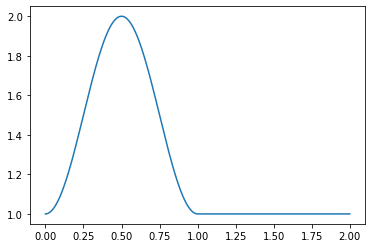

In [28]:
plt.plot(x,sine_wave(1,1))

In [29]:
def residual(un,uw,c,idxn1):
    
    # r = -u^{n} + u^{n+1} -dt*f(u^{n+1})
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r = -un + uw + f
    
    return r

In [30]:
def jacobian(u,c,idxn1):

    # J = I - dt*dfdu
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    subdiag_comp = np.ones(nx-1)
    subdiag_comp[:-1] = -c*u[1:]
        
    data = np.array([diag_comp, subdiag_comp])
    J = spdiags(data,[0,-1],nx-1,nx-1,format='csr')
    J[0,-1] = -c*u[0]
    
    return J

#     diag_comp = 1.0 + c*(2*u - u[idxn1])
#     subdiag_comp = -c*u
    
#     J = np.diag(diag_comp,0)
#     J[dn1] = subdiag_comp[1:]
#     J[0,-1] = -c*u[0]
    
#     return J

In [31]:
def solve(u0):

    u = np.zeros((nt+1,nx))
    u_inter=np.array([])
    u[0] = u0
    u_inter=np.append(u_inter,u0[:-1])
    I = sparse.eye(nx,format='csr')
    for n in range(nt): 
        uw = u[n,:-1].copy()
        r = residual(u[n,:-1],uw,c,idxn1)
        
        for k in range(maxk):
            J = jacobian(uw,c,idxn1)
            duw = spsolve(J, -r)
#             duw = np.linalg.solve(J,-r)
            uw = uw + duw
            r = residual(u[n,:-1],uw,c,idxn1)
            u_inter=np.append(u_inter,uw)

            rel_residual = np.linalg.norm(r)/np.linalg.norm(u[n,:-1])
            if rel_residual < convergence_threshold:
                u[n+1,:-1] = uw.copy()
                u[n+1,-1] = u[n+1,0]
                break
    
    return u,u_inter.reshape((-1,nx-1))

In [32]:
def generate_dataset(amp_arr,width_arr):
    
    num_amp=amp_arr.shape[0]
    num_width=width_arr.shape[0]
    data = []
    data_inter = []
    for i in range(num_amp):
        for j in range(num_width):
#             u0=square_wave(amp_arr[i],width_arr[j])
            u0=sine_wave(amp_arr[i],width_arr[j])
#             u0=gaussian(amp_arr[i],width_arr[j])
            u,u_inter=solve(u0)
            data.append(u)
            data_inter.append(u_inter)
    data = np.vstack(data)   
    data_inter = np.vstack(data_inter)   
    
    return data, data_inter

## Build a  solution snapshot

In [51]:
dn1=kth_diag_indices(np.eye(nx-1),-1)
idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

In [52]:
width_arr=np.array([1.0])
print('width_arr:',width_arr)

width_arr: [1.]


In [54]:
for nparam in [2,4,6,8,10]:

    file_name='./data/snapshot_full_nparam_{}.p'.format(nparam)
    print(file_name)
    
    amp_arr=np.linspace(0.9,1.1,num=nparam+1)
    amp_arr=np.delete(amp_arr,nparam//2)
    print('amp_arr:',amp_arr)

    snapshot_full,snapshot_full_inter = generate_dataset(amp_arr,width_arr)
    pickle.dump(snapshot_full.astype('float32'), open(file_name, "wb"))
    print(snapshot_full.shape)

./data/snapshot_full_nparam_2.p
amp_arr: [0.9 1.1]
(1002, 1001)
./data/snapshot_full_nparam_4.p
amp_arr: [0.9  0.95 1.05 1.1 ]
(2004, 1001)
./data/snapshot_full_nparam_6.p
amp_arr: [0.9        0.93333333 0.96666667 1.03333333 1.06666667 1.1       ]
(3006, 1001)
./data/snapshot_full_nparam_8.p
amp_arr: [0.9   0.925 0.95  0.975 1.025 1.05  1.075 1.1  ]
(4008, 1001)
./data/snapshot_full_nparam_10.p
amp_arr: [0.9  0.92 0.94 0.96 0.98 1.02 1.04 1.06 1.08 1.1 ]
(5010, 1001)


## FOM solution

In [55]:
amp_arr = np.array([1.0])
print('amp_arr:',amp_arr)

width_arr = np.array([1.0])
print('width_arr:',width_arr)

snapshot_full,snapshot_full_inter = generate_dataset(amp_arr,width_arr)
pickle.dump(snapshot_full.astype('float32'), open("./data/FOM.p", "wb"))
print(snapshot_full.shape)

amp_arr: [1.]
width_arr: [1.]
(501, 1001)
